# P1 - TSA - Uso de Internet en Colombia

Elaborado por GRUPO 1:
- Juanita Piraban Barbosa - 201216313
- Lorena Morales Rodríguez - 202027957
- Alejandro Barinas Guio - 201628859
- Jaime Humberto Trujillo Perea - 201920366
- Alexander Zapata Galindo - 201425426

In [3]:
# Importar Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import sys
import plotly as pt
import plotly.express as px
import warnings

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from matplotlib import pyplot
from pandas import DatetimeIndex
from pandas import Series
from tabulate import tabulate

%matplotlib inline
sns.set()  

In [4]:
# Leer el archivo 'datos.csv'
df = pd.read_excel("DataSet/P1_Serie_Uso_Internet.xlsx",index_col=0)

# Parte A. Contexto y relevancia del problema

### $\color{red}{\text{TODOS}}$ 

Para el desarrollo del proyecto, se utilizó la serie de tiempo del repositorio de datos del Banco Mundial para Colombia, correspondiente al número de personas que utilizan Internet (% de la población). 

Los usuarios de Internet son personas que han utilizado Internet (desde cualquier lugar) en los últimos tres meses. Internet puede ser usado a través de una computadora, teléfono móvil, asistente digital personal, máquina de juegos, TV digital, etc.

Fuente: https://datos.bancomundial.org/indicador/IT.NET.USER.ZS?locations=CO

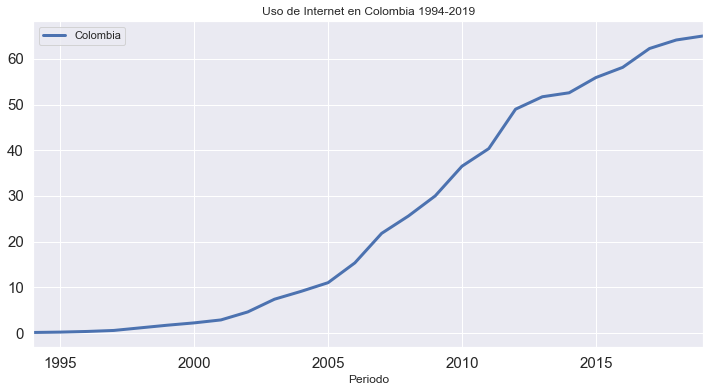

In [3]:
df.plot(figsize=(12, 6),linewidth=3, fontsize=15, title='Uso de Internet en Colombia 1994-2019');

In [4]:
df.Colombia.describe()

count    26.000000
mean     25.748213
std      24.365559
min       0.107174
25%       2.369200
50%      18.570837
75%      51.020000
max      65.006901
Name: Colombia, dtype: float64

In [5]:
table_Latam = [['Colombia','64.1%'],['Argentina','68.2%'],['Brasil','70.4%'],['México','65.8%'],['Perú','55.1%'],['Uruguay','74.8%']]
headers = ['País', 'año 2018']
print(tabulate(table_Latam,headers))

País       año 2018
---------  ----------
Colombia   64.1%
Argentina  68.2%
Brasil     70.4%
México     65.8%
Perú       55.1%
Uruguay    74.8%


In [6]:
table_GP = [['Alemania','87.0%'],['China','90.5%'],['Estados Unidos','88.5%'],['Japón','91.3%'],['OECD','82.8%'],['Reino Unido','90.7%']]
headers = ['País', 'año 2018']
print(tabulate(table_GP,headers))

País            año 2018
--------------  ----------
Alemania        87.0%
China           90.5%
Estados Unidos  88.5%
Japón           91.3%
OECD            82.8%
Reino Unido     90.7%


# Parte B. Análisis de los principales componentes de la serie

### $\color{red}{\text{JAIME}}$ 

# Estacionariedad

In [7]:
#DF Test
result = adfuller(df['Colombia'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 2.702899
p-value: 0.999087
Critical Values:
	1%: -3.924
	5%: -3.068
	10%: -2.674


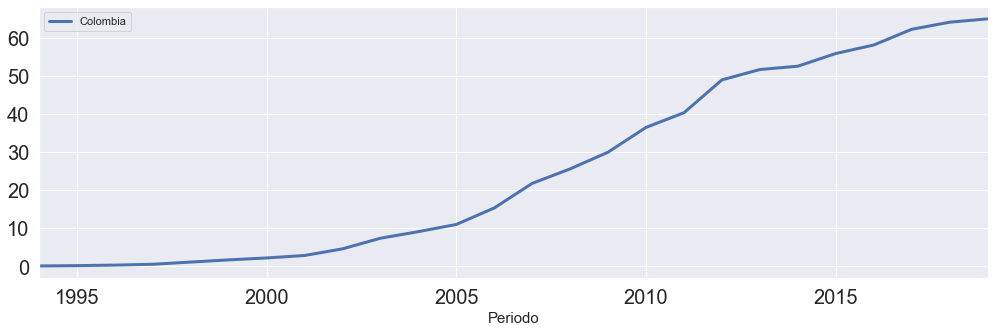

In [8]:
df.rolling(1).mean().plot(figsize=(17,5), linewidth=3, fontsize=20)
plt.xlabel('Periodo', fontsize=15);

En este caso, el test no rechaza la Ho de que la serie no es estacionaria.

# Tendencia

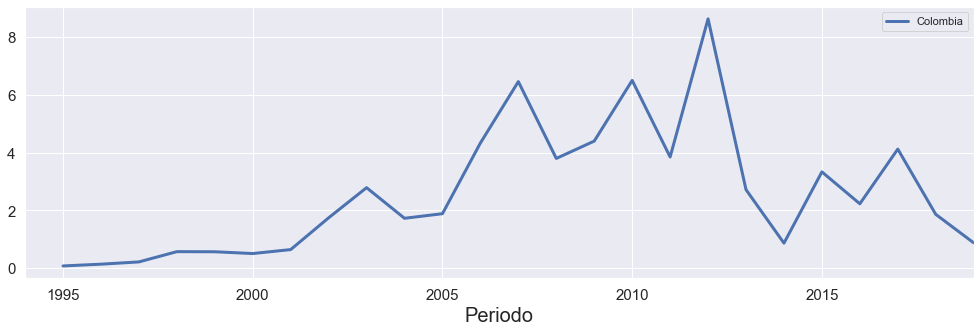

In [9]:
df.diff().plot(figsize=(17,5), linewidth=3, fontsize=15)
plt.xlabel('Periodo', fontsize=20);

In [10]:
result = adfuller(df['Colombia'].diff().iloc [ 1 :]) 
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.701676
p-value: 0.073749
Critical Values:
	1%: -3.738
	5%: -2.992
	10%: -2.636


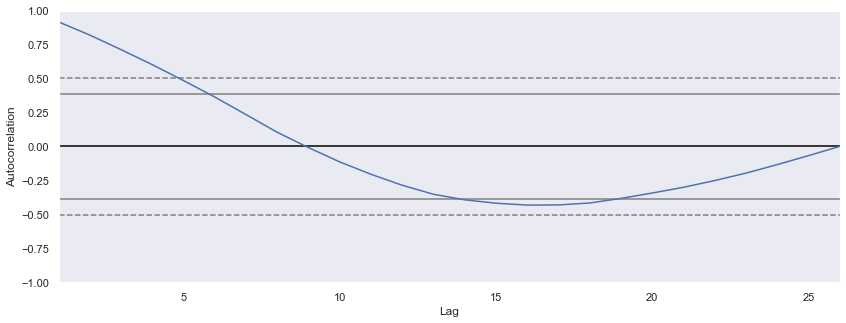

In [11]:
plt.figure(figsize=(14,5))
pd.plotting.autocorrelation_plot(df);

# Estacionalidad

# Parte C. Modelos y Proyecciones

In [12]:
warnings.filterwarnings('ignore')

## C.1. Modelos ARIMA

### $\color{red}{\text{JUANITA-ALEX}}$ 

## 1. Modelos

Se transforma la serie en logaritmo y se diferencia una vez:

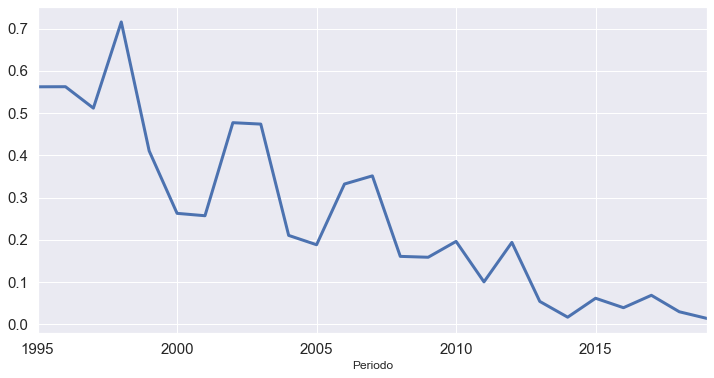

In [13]:
df['log_Colombia'] = np.log(df['Colombia'])
df_log=df.iloc[:,1:3]
df_log= df.log_Colombia.diff()
df_log=df_log.dropna()
df_log.plot(figsize=(12, 6),linewidth=3, fontsize=15);

In [14]:
result = adfuller(df_log)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.834710
p-value: 0.808713
Critical Values:
	1%: -3.889
	5%: -3.054
	10%: -2.667


La serie sigue siendo no estacionaria. Luego se diferencia una vez más.

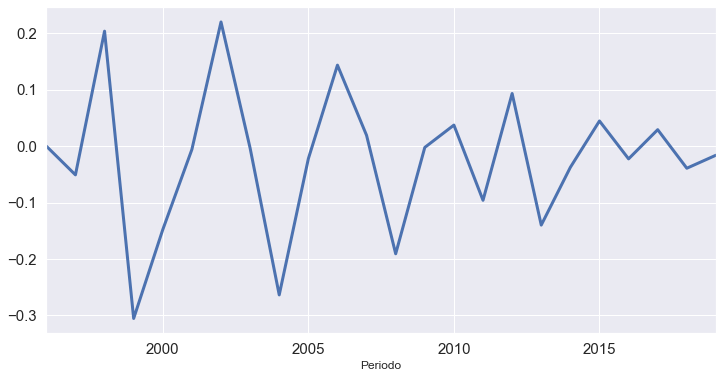

In [15]:
df_log_1= df_log.diff()
df_log_1=df_log_1.dropna()
df_log_1.plot(figsize=(12, 6),linewidth=3, fontsize=15);

In [16]:
result = adfuller(df_log_1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.201151
p-value: 0.673100
Critical Values:
	1%: -4.012
	5%: -3.104
	10%: -2.691


La serie sigue siendo no estacionaria, a pesar de las dos diferenciaciones anteriores.

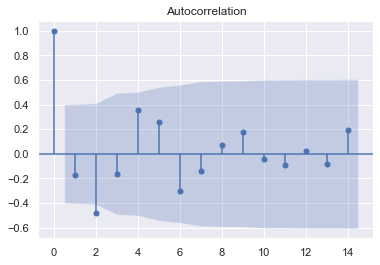

In [17]:
# Función de Autocorrelación (opción 1)
plot_acf(df_log_1);

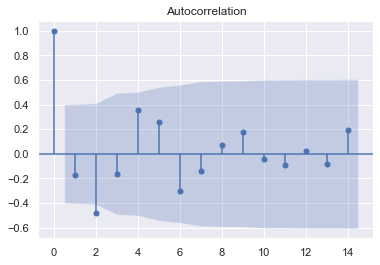

In [18]:
# Función de Autocorrelación (opción 2)
serie = np.log(df['Colombia']).diff().diff().dropna()
plot_acf(serie);

In [19]:
#Función de Autocorrelación Parcial (opción 1)
#plot_pacf(df_log_1);

In [20]:
#Función de Autocorrelación Parcial (opción 2)
#plot_pacf(serie);

In [21]:
#Bases de train y test
X = df['Colombia'].values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
future = [x for x in test]

In [22]:
# fit modelo 1 - ARIMA(2,2,1)
model1 = ARIMA(np.log(history), order=(2,2,1))
model1_fit = model1.fit(disp=0)
print(model1_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   18
Model:                 ARIMA(2, 2, 1)   Log Likelihood                  17.420
Method:                       css-mle   S.D. of innovations              0.082
Date:                Wed, 14 Jul 2021   AIC                            -24.840
Time:                        00:23:24   BIC                            -20.388
Sample:                             2   HQIC                           -24.226
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0275      0.003    -10.499      0.000      -0.033      -0.022
ar.L1.D2.y     0.0785      0.190      0.413      0.679      -0.294       0.451
ar.L2.D2.y    -0.5380      0.180     -2.983      0.0

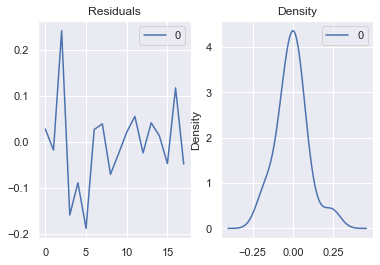

In [23]:
# plot residual errors
residuals = pd.DataFrame(model1_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

     predict       real
0  51.744581  52.570000
1  53.412187  55.904973
2  54.632893  58.136494
3  52.760135  62.259880
4  48.965324  64.126377
5  44.885423  65.006901


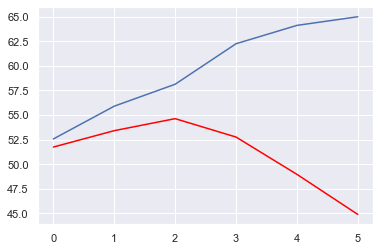

Test MSE: 124.025


In [24]:
# Real vs Proyectado
output = model1_fit.forecast(steps=len(test))[0]
yhat = output
predictions = np.exp(yhat)
real_values = future
print(pd.DataFrame({'predict':predictions, 'real':real_values}))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# MSE
mse1 = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % mse1)

In [25]:
# fit modelo 2 - ARIMA(3,2,0)
model2 = ARIMA(np.log(history), order=(3,2,0))
model2_fit = model2.fit(disp=0)
print(model2_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   18
Model:                 ARIMA(3, 2, 0)   Log Likelihood                  17.323
Method:                       css-mle   S.D. of innovations              0.087
Date:                Wed, 14 Jul 2021   AIC                            -24.647
Time:                        00:23:26   BIC                            -20.195
Sample:                             2   HQIC                           -24.033
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0300      0.007     -4.066      0.000      -0.044      -0.016
ar.L1.D2.y    -0.6584      0.170     -3.879      0.000      -0.991      -0.326
ar.L2.D2.y    -0.6591      0.143     -4.624      0.0

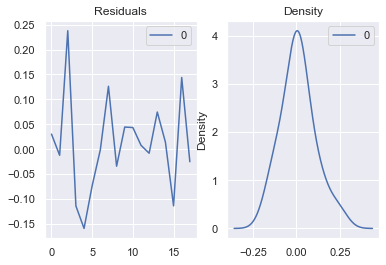

In [26]:
# plot residual errors
residuals = pd.DataFrame(model2_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

     predict       real
0  54.916436  52.570000
1  54.567381  55.904973
2  56.773911  58.136494
3  54.481842  62.259880
4  51.183434  64.126377
5  45.527067  65.006901


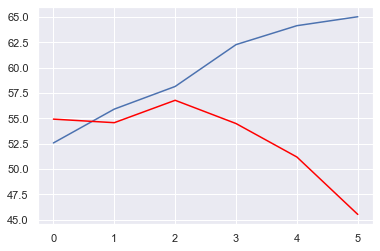

Test MSE: 102.772


In [27]:
#Real vs Proyectado
output = model2_fit.forecast(steps=len(test))[0]
yhat = output
predictions = np.exp(yhat)
real_values = future
print(pd.DataFrame({'predict':predictions, 'real':real_values}))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# MSE
mse2 = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % mse2)

In [28]:
# fit modelo 3 - ARIMA(0,2,1)
model3 = ARIMA(np.log(history), order=(0,2,1))
model3_fit = model3.fit(disp=0)
print(model3_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   18
Model:                 ARIMA(0, 2, 1)   Log Likelihood                  14.138
Method:                       css-mle   S.D. of innovations              0.102
Date:                Wed, 14 Jul 2021   AIC                            -22.276
Time:                        00:23:27   BIC                            -19.605
Sample:                             2   HQIC                           -21.908
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0272      0.004     -6.379      0.000      -0.036      -0.019
ma.L1.D2.y    -1.0000      0.149     -6.712      0.000      -1.292      -0.708
                                    Roots           

     predict       real
0  54.628428  52.570000
1  56.176158  55.904973
2  56.219960  58.136494
3  54.756314  62.259880
4  51.901874  64.126377
5  47.878116  65.006901


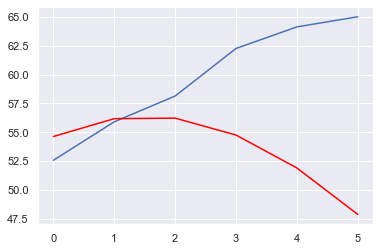

Test MSE: 84.520


In [29]:
#Real vs Proyectado
output = model3_fit.forecast(steps=len(test))[0]
yhat = output
predictions = np.exp(yhat)
real_values = future
print(pd.DataFrame({'predict':predictions, 'real':real_values}))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# MSE
mse3 = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % mse3)

In [30]:
# Comparación de MSE
table_MSE = [['ARIMA (2,2,1)', round(mse1,2)],['ARIMA (3,2,0)', round(mse2,2)],['ARIMA (0,2,1)', round(mse3,2)]]
headers = ['Modelo', 'MSE ']
print(tabulate(table_MSE,headers,stralign="decimal"))

       Modelo    MSE
-------------  ------
ARIMA (2,2,1)  124.02
ARIMA (3,2,0)  102.77
ARIMA (0,2,1)   84.52


Se selecciona el modelo ARIMA(0,2,1) por tener menor MSE.

## 2. Proyección a 5 años (fuera de la muestra)

In [31]:
#Modelo final con todos los datos
model_def = ARIMA(np.log(X), order=(0,2,1))
model_def_fit = model_def.fit(disp=0)
print(model_def_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   24
Model:                 ARIMA(0, 2, 1)   Log Likelihood                  21.618
Method:                       css-mle   S.D. of innovations              0.092
Date:                Wed, 14 Jul 2021   AIC                            -37.235
Time:                        00:23:28   BIC                            -33.701
Sample:                             2   HQIC                           -36.298
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0245      0.003     -9.619      0.000      -0.030      -0.020
ma.L1.D2.y    -1.0000      0.123     -8.161      0.000      -1.240      -0.760
                                    Roots           

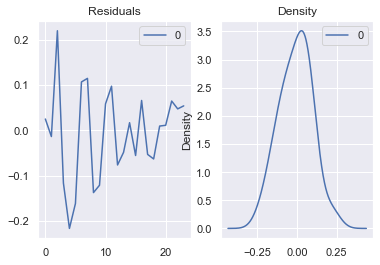

In [32]:
# plot residual errors
residuals = pd.DataFrame(model_def_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

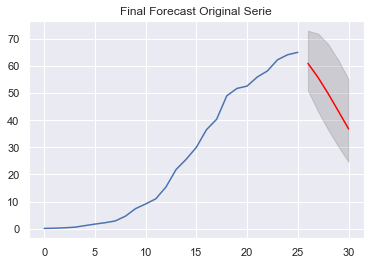

In [33]:
#Proyección por fuera de la muestra
n_periods = 5
fc, se, conf = model_def_fit.forecast(steps=n_periods)

#Extraer series
index_of_fc = np.arange(len(X), len(X)+n_periods)
fc_serie = np.exp(pd.Series(fc, index=index_of_fc))
lower_serie = np.exp(pd.Series(conf[:, 0], index=index_of_fc))
upper_serie = np.exp(pd.Series(conf[:, 1], index=index_of_fc))

# Gráfico
plt.plot(X)
plt.plot(fc_serie, color='red')
plt.fill_between(lower_serie.index,lower_serie, upper_serie, 
                 color='k', alpha=.15)
plt.title("Final Forecast Original Serie")
plt.show()

In [34]:
años=[2020,2021,2022,2023,2024]
años=pd.DataFrame(años)
table_proy = [[años[-0],round(fc_serie[:],1), round(lower_serie,1), round(upper_serie,1)]]
headers = ['Año','Proyección', 'Límite inferior','Límite superior']
print(tabulate(table_proy,headers))

Año                    Proyección      Límite inferior    Límite superior
---------------------  --------------  -----------------  -----------------
0    2020              26    60.9      26    50.9         26    73.0
1    2021              27    55.7      27    43.2         27    71.9
2    2022              28    49.7      28    36.4         28    68.0
3    2023              29    43.3      29    30.2         29    62.1
4    2024              30    36.8      30    24.6         30    55.1
Name: 0, dtype: int64  dtype: float64  dtype: float64     dtype: float64


## C.2. Modelo Prophet

In [10]:
df['log_Colombia'] = np.log(df['Colombia'])
df_log1=df.iloc[:,1:3]
df_log1= df.log_Colombia.diff()
df_log1=df_log1.dropna()

In [11]:
# Ajuste de Dataframe para que ds tenga formato fecha
df_.dtypes
df_['ds'] = pd.DatetimeIndex(df_['ds'])
df_.dtypes

NameError: name 'df_' is not defined

In [7]:
df_.head()

NameError: name 'df_' is not defined

## 1. Modelo ###

In [36]:
m = Prophet()
m.fit(df_)

ValueError: Length mismatch: Expected axis has 1 elements, new values have 2 elements

## 2. Proyección a 5 años (fuera de la muestra) ###

In [ ]:
future = m.make_future_dataframe(periods=60, freq='MS')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

# Plotting the Forecast

In [ ]:
m.plot(forecast);

# Decomposing the Forecast

In [ ]:
m.plot_components(forecast);

# Cross-validation

In [ ]:
from fbprophet.diagnostics import cross_validation

cutoffs = pd.date_range(start='2019-01-01', end='2020-11-01', freq='3MS')
print(cutoffs)

df_cv = cross_validation(model=m, horizon='180 days', cutoffs=cutoffs)

In [ ]:
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

performance_metrics(df_cv)

In [ ]:
plot_cross_validation_metric(df_cv, metric='mae');

# Conclusiones

### $\color{red}{\text{TODOS}}$ 